# Particles in a dual tree

A very simple demonstration how to use the pidt (particle in dual tree) scheme
within Peano 4.

Create a project and configure it to end up in a subnamespace (and thus subdirectory). 

In [19]:
import os

import peano4
import peano4.dastgen2
import peano4.toolbox
import peano4.toolbox.particles
import dastgen2


In [20]:
project = peano4.Project( ["examples", "particles"], "particles", "." )

## Prepare code

Peano's API does not know which settings to use on the present system. To make it copy/clone the settings identified by ./configure, we ask it to parse the generated configuration scripts. 


In [21]:
build_mode = peano4.output.CompileMode.Asserts
project.output.makefile.parse_configure_script_outcome( "../../.." )
project.output.makefile.set_mode( build_mode )

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is g++
used Fortran compiler is gfortran


## Model the particle

We create the particle through the toolbox. A particle by definition has a position. So the only thing we have to add is a velocity. We use Peano's double array to have full support of Peano's vector classes, and instead of saying that this array had two or three entries, we parameterise it through the symbol Dimensions.

In [22]:
particle  = peano4.toolbox.particles.Particle( "Particle" )
particle.data.add_attribute( peano4.dastgen2.Peano4DoubleArray("v","Dimensions") )
particles = peano4.toolbox.particles.ParticleSet( particle )

This particle has to be added to the project. This way the project knows that we are working with this guy. We associate the particle with the vertices, as we work with the pidt (particle in dual tree) algorithm. 

In [23]:
project.datamodel.add_global_object(particle)
project.datamodel.add_vertex(particles)

## Model the algorithmic steps we rely on

When we model the algorithmic steps we rely on, we use a number of pre-defined action sets from the particle toolbox. First and foremost, we use an analysed tree grammar, i.e. some marking mechanism for the tree nodes. This helps us to guide the AMR - which is the second ingredient that we use. Finally we use the plotting routines for particles from the toolbox.

In [24]:
particle_tree_analysis = peano4.toolbox.particles.ParticleTreeAnalysis(particles)
project.datamodel.add_cell(particle_tree_analysis.cell_marker)   # read docu of ParticleTreeAnalysis

### Grid/experiment setup

The first thing we will do is to create a set of particles and add them to the grid.

In [25]:
create_grid = peano4.solversteps.Step( "CreateGrid" )
create_grid.use_vertex(particles)
create_grid.use_cell(particle_tree_analysis.cell_marker)
create_grid.add_action_set( peano4.toolbox.particles.UpdateParticleGridAssociation(particles) )
create_grid.add_action_set( peano4.toolbox.particles.ParticleAMR(particles,particle_tree_analysis) )
create_grid.add_action_set( peano4.toolbox.CreateRegularGrid(0.1) )
create_grid.add_action_set( particle_tree_analysis )
project.solversteps.add_step(create_grid)

## Move particles around

We'll just give each particle a random position and velocity and move them around following this velocity. That is, we don't make the particles interact with each other et al.

In [26]:
move_particles = peano4.solversteps.Step( "MoveParticles" )
move_particles.use_vertex(particles)
move_particles.use_cell(particle_tree_analysis.cell_marker)
move_particles.add_action_set( peano4.toolbox.particles.UpdateParticleGridAssociation(particles) )
move_particles.add_action_set( peano4.toolbox.particles.ParticleAMR(particles,particle_tree_analysis) )
move_particles.add_action_set( particle_tree_analysis )

The acceleration of particles is done by injecting the interaction kernel into a predefined action set. You find a description of these sets in peano4.toolbox.particles.ParticleParticleInteraction.



ls: cannot access '../../python/peano4/toolbox/particles': No such file or directory


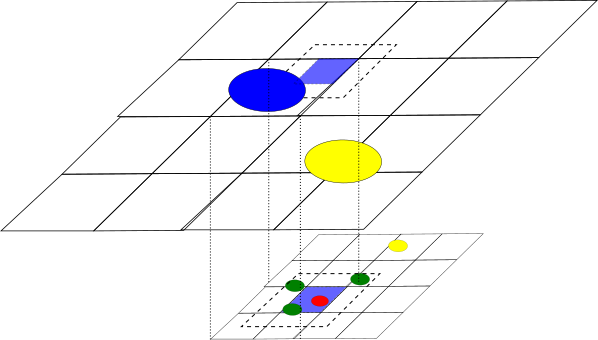

In [27]:
from IPython.display import Image
!ls ../../python/peano4/toolbox/particles
Image("../../../python/peano4/toolbox/particles/dependency_sets.png")

In [28]:
cell_compute_kernel = """
// Run over local set
for (auto& p: localParticles) {
  // Pick only those particles that reside within the current cell, otherwise
  // we'd update each particle up to 2^d times. I don't exploit the symmetry
  // of forces here
  if ( marker.isContained( p->getX() ) ) {
    tarch::la::Vector<Dimensions,double> force(0.0);
    for (auto& pp: activeParticles) {
      // No interaction with particle itself
      if (p!=pp) {
        tarch::la::Vector<Dimensions,double> dist = pp->getX() - p->getX();
        const double mass1 = p->getCutOffRadius();   // made-up hack, no real physics. But illustrates principle
        const double mass2 = pp->getCutOffRadius();  
        double forceQuantity = mass1 * mass2 / tarch::la::norm2(dist) / tarch::la::norm2(dist);
        p->setV(
          p->getV() + 0.0001 * forceQuantity / tarch::la::norm2(dist) * dist
        );
      }
    }
  }
}
"""
touch_vertex_first_time_compute_kernel = """
for (auto& p: localParticles) {
 // p is a pointer to a local particle. I don't do anything with it in this example.
}
"""

move_particles.add_action_set( peano4.toolbox.particles.ParticleParticleInteraction(particles,cell_compute_kernel,touch_vertex_first_time_compute_kernel) )
project.solversteps.add_step(move_particles)

We finally have to move the particles around. For this, I don't rely on the injected code (I could so). Instead, I wait for the Python script to run once and the implement the movement manually in the class within actionsets.

### Plots setup

I will have to plot the outcome (or any snapshot). With particles, each of my dumps produces two types of files: particle data and mesh data. For the mesh, I rely on the toolbox's grid plotting. The plot is the step where we don't need the AMR criterion - the particles don't move here after all. We however run the tree analysis, so it is up-to-date for the next step.

In [29]:
print_solution = peano4.solversteps.Step( "Plot" )
print_solution.use_vertex(particles)
print_solution.use_cell(particle_tree_analysis.cell_marker)
print_solution.remove_all_actions()
print_solution.add_action_set( peano4.toolbox.particles.UpdateParticleGridAssociation(particles) )
print_solution.add_action_set( particle_tree_analysis )
print_solution.add_action_set( peano4.toolbox.PlotGridInPeanoBlockFormat( "grid", None ) )
print_solution.add_action_set( peano4.toolbox.particles.PlotParticlesInVTKFormat( "particles", particles ) )
project.solversteps.add_step(print_solution)


## Generate the actual C++ code

Standard triad of operations. You can skip the first two steps if you want as the script then will automatically invoke the previous steps. The other way round, it is always admissible to only generate stuff, e.g., but to build and run the project through a command line.

In [30]:
project.generate()
project.build()

generate all code ...
user has to modify class CreateGrid in actions directory manually 
user has to modify class MoveParticles in actions directory manually 
generated particles-main.cpp
write ./Makefile
write ./vertexdata/ParticleSet.h (generated from template /run/media/dani/Dani_USB_SSD/Projects/MiniSPH/Peano/python/peano4/toolbox/particles/ParticleSet.template.h)
write ./vertexdata/ParticleSet.cpp (generated from template /run/media/dani/Dani_USB_SSD/Projects/MiniSPH/Peano/python/peano4/toolbox/particles/ParticleSet.template.cpp)
write ./repositories/DataRepository.h
write ./repositories/DataRepository.cpp
write ././observers/CreateGrid2peano4_toolbox_particles_UpdateParticleGridAssociation1.h
write ././observers/CreateGrid2peano4_toolbox_particles_UpdateParticleGridAssociation1.cpp
write ././observers/CreateGrid2Dummy2.h
write ././observers/CreateGrid2Dummy2.cpp
write ././observers/CreateGrid2peano4_toolbox_CreateRegularGrid3.h
write ././observers/CreateGrid2peano4_toolbox_Create

clean up project ...
clean complete
start to compile with concurrency level of 4 ...
particles-main.cpp:16:10: fatal error: observers/DataRepository.h: No such file or directory
   16 | #include "observers/DataRepository.h"
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~
compilation terminated.
make: *** [Makefile:31: particles-main.o] Error 1
make: *** Waiting for unfinished jobs....

compile not successful


## Implement the actual code

Don't forget to insert

<pre>
#include "../globaldata/Particle.h"
</pre>

## Run code

Before we run any code, we clean up, i.e. remove all old output files.

In [32]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.endswith(".pvd") ]
for f in output_files:
  os.remove(f)


#success = project.run( args=[], prefix=["mpirun", "-n", "1"] )

In [33]:
# success = project.run( args=["--threads", "1"], prefix=["mpirun", "-n", "1"] )
!./peano4

/bin/bash: ./peano4: No such file or directory


## Visualise outcome

There are different ways how to visualise the grid data, as it is written in Peano's mesh format. The particle data in contrast is plain vtu which Paraview can render directly. I do recommend to use Peano's Python scripts within Paraview to visualise the mesh. For this, ensure that your Pythonpath points to Peano's python subdirectory before you launch Paraview. Within the vis tool, open the Python terminal and type in:

<pre>
import peano4.visualisation
visualiser = peano4.visualisation.Visualiser( "grid.peano-patch-file" )
visualiser.display()
</pre>

By typing in 
<pre>
visualiser.select_dataset(x)
visualiser.reload()
</pre>

you can visualise snapshot x. At the moment, we have not yet integrated our Python vis with Paraview's timestepping/animation interface.

Alternatively, you can type in
<pre>
export PYTHONPATH=../../python/
pvpython ../../python/peano4/visualisation/render.py grid.peano-patch-file
</pre>
